# Text Classification using Deep Learning & Projecting the Embeddings 📣

##### Author : Deepak John Reji

Linked In: https://www.linkedin.com/in/deepak-john-reji/

#### Importing Packages

In [25]:
import os
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
import tensorflow as tf;
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

#### Loading the Data

In [2]:
os.chdir(r'xxxx\xxxx\xxxxx\xxxx')
datastore = pd.read_excel('train_tweets.xlsx')
datastore.head()

,tweet,label
0,@user when a father is dysfunctional and is s...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,0
4,factsguide: society now #motivation,0


#### Text cleaning

In [3]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text = text.replace('#', '')
    #text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [26]:
datastore['tweet'] = datastore['tweet'].apply(clean_text)
datastore['tweet'] = datastore['tweet'].str.replace('\d+', '')

C:\Users\deepak.reji\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


<AxesSubplot:>

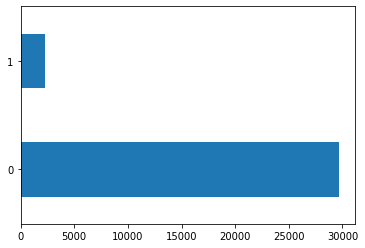

In [5]:
datastore['label'].value_counts().plot(kind='barh')

#### Train-Test Split

In [6]:
positive = datastore[datastore['label'] == 1]
negative = datastore[datastore['label'] == 0]

training = pd.concat([positive[:2000], negative[:20000]], ignore_index=True)
testing = pd.concat([positive[2000:], negative[20000:]], ignore_index=True)

training_sentences = training['tweet'].tolist()
training_labels = training['label'].tolist()
testing_sentences = testing['tweet'].tolist()
testing_labels = testing['label'].tolist()

### Training the Model

##### Model Configuration

In [15]:
vocab_size = 500
embedding_dim = 8
max_length = 30
trunc_type = 'post'
oov_tok = "<OOV>"
padding_type='post'

In [16]:
tokenizer = Tokenizer(num_words=vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
print(word_index)

{'<OOV>': 1, 'user': 2, 'love': 3, 'day': 4, 'amp': 5, 'happy': 6, 'u': 7, 'life': 8, 'im': 9, 'time': 10, 'like': 11, 'today': 12, 'new': 13, 'positive': 14, 'people': 15, 'get': 16, 'thankful': 17, 'bihday': 18, 'good': 19, 'cant': 20, 'one': 21, 'dont': 22, 'see': 23, 'smile': 24, 'fathers': 25, 'go': 26, 'want': 27, 'work': 28, 'take': 29, 'weekend': 30, 'fun': 31, 'healthy': 32, 'summer': 33, 'got': 34, 'days': 35, 'family': 36, 'make': 37, 'friday': 38, 'great': 39, 'going': 40, 'friends': 41, 'us': 42, 'best': 43, 'beautiful': 44, 'bull': 45, 'way': 46, 'need': 47, 'wait': 48, 'first': 49, 'music': 50, 'really': 51, 'world': 52, 'fathersday': 53, 'morning': 54, 'back': 55, 'know': 56, 'tomorrow': 57, 'trump': 58, 'ur': 59, 'never': 60, 'sad': 61, 'week': 62, 'feel': 63, 'think': 64, 'am': 65, 'blog': 66, 'cute': 67, 'happiness': 68, 'home': 69, 'affirmation': 70, 'right': 71, 'orlando': 72, 'night': 73, 'model': 74, 'net': 75, 'much': 76, 'last': 77, 'girl': 78, 'always': 79, 'l

In [17]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(training_sequences[0])
print(training_padded[0])

[2, 1, 1, 1, 1, 169, 1, 1, 1, 1]
[  2   1   1   1   1 169   1   1   1   1   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


In [18]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(testing_sequences[0])
print(testing_padded[0])


[2, 319, 1, 1, 1, 1, 1, 1]
[  2 319   1   1   1   1   1   1   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


In [19]:
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

##### Model Architecture

In [20]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        #tf.keras.layers.Flatten(),
        tf.keras.layers.GlobalAveragePooling1D(),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(6, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
        ])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 8)             4000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 6)                 54        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 4,061
Trainable params: 4,061
Non-trainable params: 0
_________________________________________________________________


##### Training

In [21]:
num_epochs = 3
history = model.fit(training_padded, training_labels, epochs = num_epochs, 
                    validation_data = (testing_padded, testing_labels), verbose=2)

Train on 22000 samples, validate on 9962 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
 - 3s - loss: 0.3890 - acc: 0.9030 - val_loss: 0.1436 - val_acc: 0.9757
Epoch 2/3
 - 2s - loss: 0.2869 - acc: 0.9091 - val_loss: 0.1428 - val_acc: 0.9757
Epoch 3/3
 - 2s - loss: 0.2651 - acc: 0.9091 - val_loss: 0.1296 - val_acc: 0.9757


In [22]:
test_loss, test_acc = model.evaluate(testing_padded, testing_labels)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

9962/9962 [==============================] - 1s 57us/sample - loss: 0.1296 - acc: 0.9757
Test Loss: 0.1296315447626835
Test Accuracy: 0.9757077097892761


##### Plotting the Results

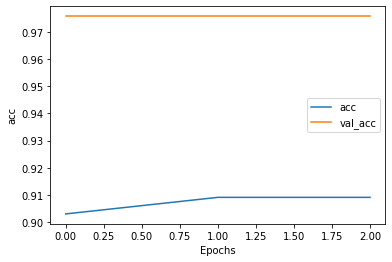

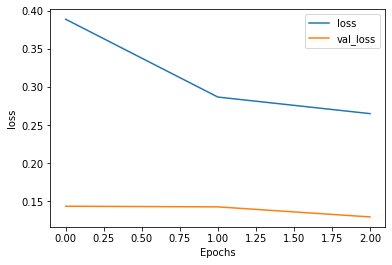

In [23]:
# plotting the results
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

### Visualizing the results in Embeddings Projector

In [24]:
import io

e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

(500, 8)


Load the tsv files created using the above code block and project it in Embeddings Projector

https://projector.tensorflow.org/